In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Embedding, LSTM, Activation, Conv1D, MaxPooling1D
from keras.datasets import mnist
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import LeakyReLU, BatchNormalization, Reshape, Input, UpSampling2D
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras_preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
# GPU 사용 초기화 및 할당.
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

import warnings
warnings.filterwarnings('ignore')

* 오토인코더(Auto-Encoder) : 입력층과 출력층이 같은 구조.

    * 인코더(encoder) : 인지 네트워크(recognition network)라고도 하며, 입력을 내부 표현으로 변환.
    * 디코더(decoder) : 생성 네트워크(generative nework)라고도 하며, 내부 표현을 출력으로 변환.
<br>
<br>
* < 특징 >
* 정밀하지는 않지만 학습량이 작을 때 사용하기 좋음.
* 글 등과 같은 선명할 필요없는 이미지에 적합.
* 적어도 입력값에 대해서는 복원을 잘함.
* 오토인코더(Auto-Encoder)는 실제로 입력 데이터의 Feature를 추출할 때 많이 사용.
* 주로 차원축소(Dimension Reduction)에 사용.
    * Network parameter 초기화, pre-training에 많이 사용.

In [2]:
# seed 값 설정.
np.random.seed(3)
tf.random.set_seed(3)

# 데이터 불러오기.
from keras.datasets import mnist
(x_train, _), (x_test,_) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

# 데이터 표준화.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test  = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)


In [6]:
# 오토인코더는 두 가지 단계( 인코딩 단계와 디코딩 단계)를 거쳐 입력값을 재구성함.
# 생성자 모델 생성.
AutoEncoder = Sequential()

# 인코딩. => 입력값의 차원을 축소. = 데이터 압축을 의미.
AutoEncoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
AutoEncoder.add(MaxPooling2D(pool_size=2, padding='same'))

AutoEncoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
AutoEncoder.add(MaxPooling2D(pool_size=2, padding='same'))

AutoEncoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu', strides=2))


# 디코딩. => 인코딩한 압축 정보를 원본 데이터로 복원.
AutoEncoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
AutoEncoder.add(UpSampling2D())

AutoEncoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
AutoEncoder.add(UpSampling2D())

AutoEncoder.add(Conv2D(16, kernel_size=3, activation='relu'))
AutoEncoder.add(UpSampling2D())

AutoEncoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

In [7]:
AutoEncoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 8, 8, 8)          

In [8]:
# 학습.
AutoEncoder.compile(loss='binary_crossentropy', optimizer='adam')
AutoEncoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 15s 16ms/step - loss: 0.3146 - val_loss: 0.1358
Epoch 2/50
469/469 [==============================] - 6s 14ms/step - loss: 0.1318 - val_loss: 0.1173
Epoch 3/50
469/469 [==============================] - 6s 14ms/step - loss: 0.1160 - val_loss: 0.1086
Epoch 4/50
469/469 [==============================] - 6s 14ms/step - loss: 0.1086 - val_loss: 0.1035
Epoch 5/50
469/469 [==============================] - 7s 14ms/step - loss: 0.1041 - val_loss: 0.1002
Epoch 6/50
469/469 [==============================] - 7s 14ms/step - loss: 0.1005 - val_loss: 0.0973
Epoch 7/50
469/469 [==============================] - 6s 14ms/step - loss: 0.0980 - val_loss: 0.0952
Epoch 8/50
469/469 [==============================] - 6s 14ms/step - loss: 0.0958 - val_loss: 0.0941
Epoch 9/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0942 - val_loss: 0.0922
Epoch 10/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0931 - val_l

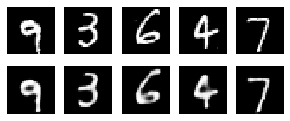

In [15]:
# 무작위로 5개 이미지 추출.
random_test = np.random.randint(x_test.shape[0], size=5)

# 예측 이미지 생성.
AE_img = AutoEncoder.predict(x_test)

# 출력될 이미지의 크기.
plt.figure(figsize=(7, 2))
for i, img_idx in enumerate(random_test):
    
    # 원본 이미지.
    ax = plt.subplot(2, 7, i+1)
    plt.imshow(x_test[img_idx].reshape(28,28), cmap='gray')
    ax.axis('off')
    
    # 예측 이미지.
    ax = plt.subplot(2, 7, 7+i+1)
    plt.imshow(AE_img[img_idx].reshape(28,28), cmap='gray')
    ax.axis('off')
plt.show()